딥러닝 파이토치 교과서 ch5. 2 p.179~200

### **[개념 정리+코드 필사]📝**

### **5.2 합성곱 신경망 맛보기**

- fashion_mnist 데이터셋으로 합성곱 신경망 구현 실습
  - 0: T-shirt, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle Boot
  - 토치비전으로 다운받기(torchvision.datasets): 위치 지정, 이미지를 텐서변경
- 기본적으로 GPU 사용 권장
- 데이터로더로 원하는 크기의 배치단위로 데이터 불러오기 - torch.utils.data.DataLoader(데이터셋, batch_size=100)
- 코드(5): 레이블 클래스 정의, 랜덤으로 시각화
  - np.random.randint(len(train_dataset)): 0~train_dataset 길이 분포중 랜덤 숫자 하나 생성
  - train_dataset[random수][0][0,:,:]: 랜덤 이미지 한개 뽑기. 반복



In [ ]:
# 1
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
# 2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# 3
train_dataset = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 301kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.85MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.1MB/s]


In [ ]:
# 4 데이터를 데이터로더로 전달
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

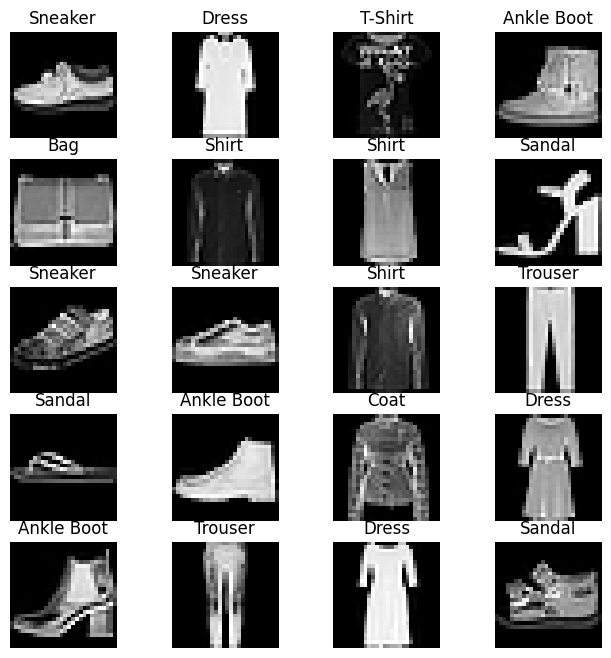

In [ ]:
# 5 분류에 사용될 클래스 정의
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker',
              8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize=(8, 8));
columns = 4;
rows = 5;
for i in range(1, columns*rows+1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0,:,:];
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show()

- 코드(6): 클래스 형태의 모델 -> 항상 torch.nn.Module 상속
  - 📄 __init __() : 객체의 속성 값 초기화(독립적 구현), 객체 생성 시 자동 호출
  - 📄 super(FashionDNN, self).__init __(): nn.Module 클래스 상속받음
    - 객체명 = 클래스명()
  - 📄 nn: 딥러닝 모델이 필요한 모듈이 모여 있는 패키지. nn.Linear(in_feautures, out_features): 단순선형회귀모델에 사용
  - torch.nn.Dropout(p): p만큼의 비율로 텐서값이 0이 되고, 나머지 값은 1/(1-p)만큼 곱해져 커짐
  - 📄 forward(): 순전파 학습 진행(학습 데이터 이용)
  - 📄 veiw(): 넘파이의 reshape()
  - 활성화 함수 지정
    - F.relu(): forward()에서 정의
    - nn.ReLU(): __init __()에서 정의

    ```
    conv = nn .Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
    outputs = F.conv2d(inputs, weight , bias, padding=1)
    ```

    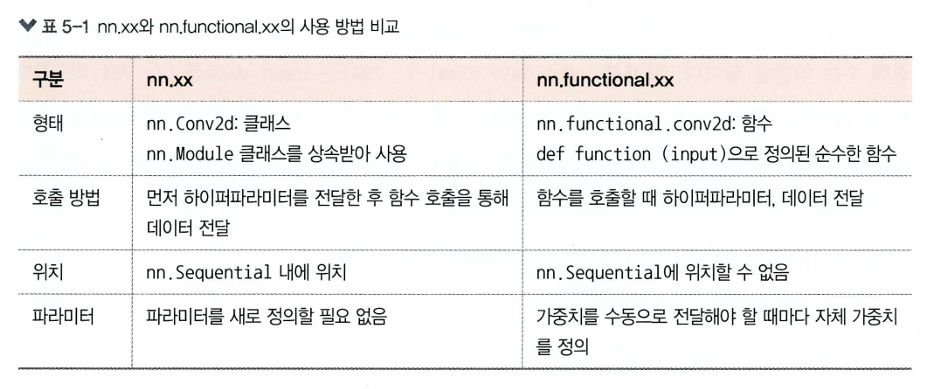





In [ ]:
# 5-6 심층 신경망 모델 생성
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

- 코드(7): 학습 전 손실 함수, 학습률, 옵티마이저 정의
  - 경사하강법은 Adam 사용, lr(학습률)
- 코드(8): 심층 신경망에 데이터를 적용해 모델 학습
  - 모델과 데이터가 동일 장치에 있어야함. model.to(device), labels.to(device)동일한 곳에서 처리해야 오류 안남
  - Autograd: 자동미분 수행하는 패키지. 자동미분값을 테이프에 모두 저장하고 역전파에서 꺼내 사용. torch.autograd안의 Variable 이용
  - 정확도: 정확예측/전체예측
  - 오분류율: 1-정확도
  - 클래스가 3개 이상일때는 정확도 해석에 유의
    - 80%일때 모든 클래스가 동등하게 고려된건지 특정 클래스의 분류가 높은건지 알수 없음
    - 모든 데이터를 클래스 하나에 속한다해도 90%의 예측 결과가 나올 수 있음
- 모델 훈련 결과 출력
- 최종 정확도 확인

In [ ]:
# 5-7 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# 5-8 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

      if not (count % 500):
        print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))


Iteration: 500, Loss: 0.5750075578689575, Accuracy: 83.05000305175781%
Iteration: 1000, Loss: 0.43968939781188965, Accuracy: 84.36000061035156%
Iteration: 1500, Loss: 0.3208136260509491, Accuracy: 84.37999725341797%
Iteration: 2000, Loss: 0.42301705479621887, Accuracy: 85.62999725341797%
Iteration: 2500, Loss: 0.25259163975715637, Accuracy: 86.3499984741211%
Iteration: 3000, Loss: 0.2628782391548157, Accuracy: 87.0%


- 코드(9): **합성곱 신경망** 생성 ✅
  - nn.Sequential()사용: __init __()에서 사용하는 모델 정의, forward()에서 구현될 순전파를 계층 형태로 작성 가능
    - 수식과 활성화 함수를 연결해 가독성이 뛰어남
    - 여러 개의 계층을 하나의 컨테이너에 구현
  - 합성곱층: 합성곱 연산으로 이미지 특징 추출
    - 합성곱: 커널 행렬이 이미지를 흝으면서 각 원소 값끼리 곱한 후 모두 더한 값 출력
    - 채널: 3차원으로 생각하면 깊이를 의미
    - in_channels: 입력 채널 수(흑백=1, RGB=3), out_channels: 출력 채널 수, kernel_size: 커널 크기, padding: 패딩 크기
  - BatchNorm2d: 각 배치 단위별로 데이터가 다양한 분포를 가져도 정규화하는 것. 입력 값의 분포가 달라도 정규화로 가우시안 분포를 만들어 조정
  - nn.MaxPool2d(kernel_size=2, stride=2): 이미지 축소. 풀링계층으로 합성곱층의 데이터를 입력받아 출력 데이터 크기를 줄임
    - 최대 풀링, 평균 풀링, 최소 풀링
    - kernel_size: 행렬로 구성된 가중치
    - stride: 입력 데이터에 커널을 적용할 때 이동할 간격. 커지면 출력 크기는 작아짐
- 클래스 분류 위해 이미지 데이터 -> 배열로 변환
  -  Conv2d(패딩, 스트라이드 값에 따라 출력 크기 달라짐) -> 분류 담당 완전연결층으로 전달
  - nn.Linear(in_features=64*6 *6, out_feautures=600)
    - in_features: 입력데이터 크기
  - Conv2d, MaxPool2d의 입력 데이터는 이미지 데이터. 완전연결층은 1차원 입력받음
    - ♣ Conv2d의 출력 크기 = (입력 데이터 크기-커널크기+2*패딩크기)/스트라이드+1
    - ♣ MaxPool2d의 출력 크기 = 입력필터 크기/커널크기
- .view(.size(0),-1): 합성곱층 -> 완전연결층이므로 데이터 형태 1차원으로 변경

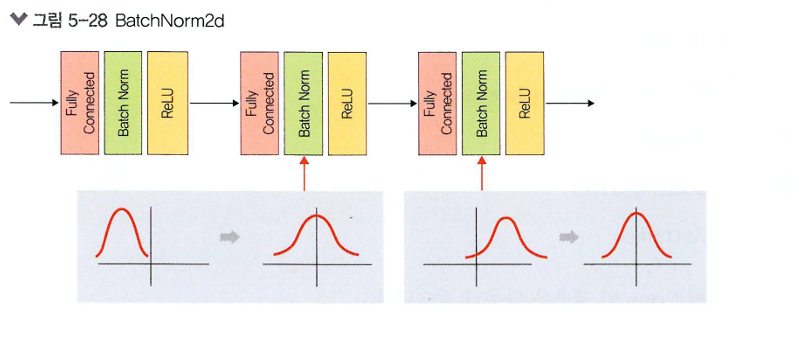



In [ ]:
# 5-9 합성곱 네트워크 생성
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

- 코드(10): 합성곱 네트워크 위한 파라미터 정의, 네트워크 구조 출력결과 확인

In [ ]:
# 5-10 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


- 코드(11): 학습 데이터로 모델 학습(코드(8)과 동일)
- 심층 신경망보다 정확도가 약간 높음. 이미지 데이터가 많아질수록 합성곱 신경망이 더 정확한 분류 가능

In [ ]:
# 5-11 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count +=1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        prediction_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4969794750213623, Accuracy: 87.69000244140625%
Iteration: 1000, Loss: 0.3209590017795563, Accuracy: 87.93000030517578%
Iteration: 1500, Loss: 0.31890377402305603, Accuracy: 88.98999786376953%
Iteration: 2000, Loss: 0.21505555510520935, Accuracy: 89.16000366210938%
Iteration: 2500, Loss: 0.1666231006383896, Accuracy: 89.69999694824219%
Iteration: 3000, Loss: 0.18540005385875702, Accuracy: 89.5%
